## 1. ОБРАБОТКА ДАННЫХ ИЗ РЕЕСТРА

### 1.1 Настройка библиотек

#### 1.1.1 Библиотеки для работы с директориями

In [1]:
import os
import sys
import csv

#### 1.1.2 Библиотеки для работы с данными

In [2]:
# Для обработки таблиц и работы с массивами
import re
import numpy as np
import pandas as pd
import openpyxl
import json

import warnings

# Отключение предупреждений, возникающих при чтении данных
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl.styles.stylesheet')

#### 1.1.3 Библиотеки для работы с графиками

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

#### 1.1.4 Прочие библиотеки

In [4]:
from datetime import datetime

### 1.2 Настройка директорий

In [5]:
this_directory = os.getcwd()

dipl_directory = this_directory.split('main_folder')[0]
data_directory = dipl_directory + 'raw_data'

# В WIN подключение к данным выглядит так:
xlsx_directory = data_directory + '\\excel\\'
dcsv_directory = data_directory + '\\csv\\'

### 1.3 Пересохранение данных из excel в csv (если это требуется)

In [6]:
# Функция пересохранения файла
def excel_to_csv(name_file_excel: str, page_save: str, name_file_csv: str):
    file_open = pd.read_excel(name_file_excel, sheet_name=page_save)
    file_open.to_csv(name_file_csv, index=False)

In [7]:
# M_name = 'reestr_re_sold_M.xlsx'
# MO_name = 'reestr_re_sold_MO.xlsx'
# NM_name = 'reestr_re_sold_NM.xlsx'
# SPB_name = 'reestr_re_sold_SPB.xlsx'
# LO_name = 'reestr_re_sold_LO.xlsx'

# # Структура данных из реестра:
# # 1. (reestr_re_sold_M) Москва - объём проданных площадей, контрактация и описательная статистика ЖК 
# # 2. (reestr_re_sold_MO) Московская область - объём проданных площадей, контрактация и описательная статистика ЖК
# # 3. (reestr_re_sold_NM) Новая Москва - объём проданных площадей, контрактация и описательная статистика ЖК
# # 4. (reestr_re_sold_SPB) Санкт-Петербург - объём проданных площадей, контрактация и описательная статистика ЖК
# # 5. (reestr_re_sold_LO) Ленинградская область - объём проданных площадей, контрактация и описательная статистика ЖК
# excel_to_csv(xlsx_directory + M_name, 'Данные', dcsv_directory + 'realty_sold_M.csv')
# excel_to_csv(xlsx_directory + MO_name, 'Данные', dcsv_directory + 'realty_sold_MO.csv')
# excel_to_csv(xlsx_directory + NM_name, 'Данные', dcsv_directory + 'realty_sold_NM.csv')
# excel_to_csv(xlsx_directory + SPB_name, 'Данные', dcsv_directory + 'realty_sold_SPB.csv')
# excel_to_csv(xlsx_directory + LO_name, 'Данные', dcsv_directory + 'realty_sold_LO.csv')

### 1.4 Первичная обработка данных

In [8]:
os.chdir(dcsv_directory)

csv_msk = pd.read_csv('realty_sold_M.csv', low_memory=False)
csv_mo = pd.read_csv('realty_sold_MO.csv', low_memory=False)
csv_nm = pd.read_csv('realty_sold_NM.csv', low_memory=False)
# csv_spb = pd.read_csv('realty_sold_SPB.csv', low_memory=False)
# csv_lo = pd.read_csv('realty_sold_LO.csv', low_memory=False)

In [9]:
# lst_tbls = [csv_msk.columns, csv_mo.columns, csv_nm.columns, csv_spb.columns, csv_lo.columns]
lst_tbls = [csv_msk.columns, csv_mo.columns, csv_nm.columns]

#### 1.4.1 Установка временного промежутка  

Простая функция обработки дат и отбор от 2018 года

In [10]:
def first_prepare(df: object) -> object:
    
    # Обработка дат
    start_date = datetime(2018, 1, 1)
    end_date = datetime(2025, 1, 1)

    df['Дата регистрации'] = pd.to_datetime(df['Дата регистрации'])
    new_df = df[(df['Дата регистрации'] >= start_date) & (df['Дата регистрации'] < end_date)]
    
    return new_df

Список параметров, которые оставляем в таблице для обработки и использования

In [11]:
columns_select = [
                'ID ЖК',                            # обработка не требуется
                'ЖК рус',                           # обработано
                'Цена со скидкой',                  # обработка не требуется
                'Район Город',                      # обработано
                'Регион',                           # обработано (на случай конката таблиц из разных регионов)
                'Застройщик ЖК',                    # обработано
                'Площадь',                          # обработка не требуется
                'Тип Комнатности',                  # обработано
                'Этаж',                             # обработка не требуется
                'Тип помещения',                    # обработано
                'Дата регистрации',                 # обработано
                'Условия обременения',              # обработано
                'Дата обременения',                 # обработано
                'Залогодержатель',                  # обработано             
                'Длительность обременения',         # обработано
                'Тип обременения',                  # обработано
                'Дата ДДУ',                         # обработано
                'Уступка',                          # обработка не требуется
                'Купил лотов в ЖК',                 # обработано
                'Покупатель ЮЛ',                    # ВАЖНО
                'класс',                            # обработано
                'Срок сдачи',                       
                'lat',                              # обработка не требуется
                'lng',                              # обработка не требуется
                'Ипотека',                          # обработка не требуется
                'Отделка',                          # обработано
                'Старт продаж К',                   # обработано
                # 'Продавец ЮЛ',
                'Зона',                             # обработано
                # 'Купил кв и ап в ЖК',             
                'Стадия строительства в дату ДДУ'   # обработано
                ]

In [12]:
# --------------------------------------------------------
# Обработка таблиц на даты
msk_date_update = first_prepare(csv_msk)
mo_date_update = first_prepare(csv_mo)
nm_date_update = first_prepare(csv_nm)
# lo_date_update = first_prepare(csv_lo)
# spb_date_update = first_prepare(csv_spb)

# Очистка памяти
csv_msk = None
csv_mo = None
csv_nm = None
# csv_lo = None
# csv_spb = None

# --------------------------------------------------------
# Обработка таблиц на параметры
new_msk = msk_date_update[columns_select]
new_mo = mo_date_update[columns_select]
new_nm = nm_date_update[columns_select]
# new_lo = lo_date_update[columns_select]
# new_spb = spb_date_update[columns_select]

# Повторная очистка памяти
msk_date_update = None
mo_date_update = None
nm_date_update = None
# lo_date_update = None
# spb_date_update = None

#### 1.4.2 Настройка длительности обременения

In [13]:
'''
ФУНКЦИЯ ИЗВЛЕЧЕНИЯ ДЛИТЕЛЬНОСТИ ОБРЕМЕНЕНИЯ ИЗ ТЕКСТА
Возвращает:
- Количество месяцев как целое число
- None если не смогла распознать параметр
'''
def extract_duration_months(text, mortgage_date):

    text = str(text).lower().strip()
    
    # Кейс 1: чёткое задано количество месяцев
    month_patterns = [
                    r'(\d+)\s*(?:мес|месяц|месяца|месяцев|мес\.|\bмес\b)',
                    r'на\s*(\d+)\s*месяц',
                    r'(\d+)\s*калер?нд?а?р?н?ы?х?\s*(?:месяц|дн)',
                    r'(\d+)\s*процент(?:ных|ый|ых)\s*период',
                    r'(\d+)\s*%\s*период',
                    r'(\d+)\s*vtczw',
                    r'(\d+)\s*(?:иес|есяц|сес|инс|дн|дней)',
                    r'срок\s*(?:кредита|займа|возврата)\s*(\d+)',
                    r'срок\s*(?:кредита|займа|возврата)[^0-9]+(\d+)',
                    r'на\s*срок\s*(\d+)',
                    r'на\s*(\d+)',
                    r'последнее\s*число\s*(\d+)',
                    r'по\s*(?:последнее\s*число|последнее)\s*(\d+)',
                    r'по\s*(\d+)[\s\-]*(?:е|ое|го)',
                    r'(\d+)[\s\-]*(?:ого|его|го|ый|ий|й)',
                    ]

    for pattern in month_patterns:
        match = re.search(pattern, text)
        if match:
            try:
                num = int(match.group(1))
                # Если число слишком большое (например, 2340), вероятно это опечатка
                if num > 1000 and num < 10000:
                    # Попробуем понять, что имелось в виду
                    if num // 100 <= 36:    # максимум 36 лет (432 месяца)
                        return num // 10    # например, 2340 -> 234 месяцев
                    else:
                        return num // 100   # например, 6385 -> 63 месяца
                return num
            except:
                pass

    # Проверка на конкретные числа месяцев в тексте
    if re.search(r'\b360\b', text) or "триста шестьдесят" in text:
        return 360
    elif re.search(r'\b300\b', text) or "триста" in text:
        return 300
    elif re.search(r'\b240\b', text) or "двести сорок" in text:
        return 240
    elif re.search(r'\b180\b', text) or "сто восемьдесят" in text:
        return 180
    elif re.search(r'\b144\b', text) or "сто сорок четыре" in text:
        return 144
    elif re.search(r'\b120\b', text) or "сто двадцать" in text:
        return 120
    elif re.search(r'\b96\b', text) or "девяносто шесть" in text:
        return 96
    elif re.search(r'\b84\b', text) or "восемьдесят четыре" in text:
        return 84
    
    # Кейс 2: дата до конкретной даты
    date_patterns = [
                    r'до\s*(\d{1,2})\./-](\d{1,2})[\./-',
                    r'до\s*(\d{1,2})\s*(\w+)\s*(\d{4})',
                    r'по\s*(\d{1,2})\./-](\d{1,2})[\./-',
                    r'по\s*(\d{1,2})\s*(\w+)\s*(\d{4})',
                    r'(?:по|до)\s*(\d{2})\.(\d{2})\.(\d{4})',
                    r'(?:по|до)\s*(\d{2}),\s](\d{2})[,\s',
                    r'(?:по|до)\s*(\d{1,2}),\s](\d{1,2})[,\s',
                    r'(\d{2})\.(\d{2})\.(\d{4})\s*(?:г|год)',
                    r'(\d{2})\.(\d{2})\.(\d{4})',
                    r'(\d{1,2})\.(\d{1,2})\.(\d{4})',
                    ]
            
    if mortgage_date is not None and not pd.isna(mortgage_date):
        for pattern in date_patterns:
            try:
                match = re.search(pattern, text)
                if match:
                    end_date = None
                    
                    if len(match.groups()) == 3 and len(match.group(2)) > 2:
                        month_map = {
                                    'январ': 1, 'феврал': 2, 'март': 3, 'апрел': 4, 'май': 5, 'мая': 5,
                                    'июн': 6, 'июл': 7, 'август': 8, 'сентябр': 9, 'октябр': 10, 
                                    'ноябр': 11, 'декабр': 12
                                    }
                        
                        day = int(match.group(1))
                        month_text = match.group(2).lower()
                        
                    else:
                        day = int(match.group(1))
                        month = int(match.group(2))
                        year = int(match.group(3))

                        if year < 100:
                            year += 2000
                            
                        end_date = datetime(year, month, day)
                    
                    if end_date:
                        start_date = pd.to_datetime(mortgage_date)
                        months_diff = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
                        
                        if months_diff > 0:
                            return months_diff
                        
            except:
                pass
            
    # Кейс 3: отдельные случаи
    if '360' in text:
        return 360
    elif '300' in text:
        return 300
    elif '240' in text:
        return 240
    elif '180' in text:
        return 180
    elif '120' in text:
        return 120
            
    # Кейс 4: общие положения по ипотеке
    if 'до полного исполнения' in text or 'до полного погашения' in text or 'до полной выплаты' in text:
        return 360
    
    return None


In [14]:
new_msk['Длительность обременения месяцы'] = new_msk.apply(lambda row: extract_duration_months(row['Условия обременения'], row['Дата обременения']), axis=1) 
new_mo['Длительность обременения месяцы'] = new_mo.apply(lambda row: extract_duration_months(row['Условия обременения'], row['Дата обременения']), axis=1)
new_nm['Длительность обременения месяцы'] = new_nm.apply(lambda row: extract_duration_months(row['Условия обременения'], row['Дата обременения']), axis=1)
# new_lo['Длительность обременения месяцы'] = new_lo.apply(lambda row: extract_duration_months(row['Условия обременения'], row['Дата обременения']), axis=1)
# new_spb['Длительность обременения месяцы'] = new_spb.apply(lambda row: extract_duration_months(row['Условия обременения'], row['Дата обременения']), axis=1)

### 1.5 Обработка отдельных столбцов

In [15]:
''' 
Преобразует и фильтрует данные о недвижимости, возвращая очищенный датафрейм и статистику по отфильтрованным записям.

Args:
- new_csv: Исходный датафрейм
- region_long: Полное название региона
- region_short: Сокращенное название региона
    
Returns:
- tuple: (очищенный датафрейм, словарь со статистикой фильтрации)

'''
def data_reform(new_csv: object, region_long: str, region_short: str) -> tuple:
    
    # Создаем словарь для хранения статистики фильтрации
    filter_stats = {
                    'region': region_long,
                    'initial_records': len(new_csv),
                    'filtered_records': {},
                    'total_filtered': 0
                    }
    
    # Создаем копию исходного датафрейма
    original_csv = new_csv.copy()
    new_csv = new_csv.copy()
    
    # ------------------------------------------------------------------------------------------
    # (реновация), (офисы), (регион)
    ''' Меняем наименования ЖК + добавляем к каждому приписку "ЖК " '''

    name_to_change = ' ({})'.format(region_long)

    new_csv['ЖК рус'] = new_csv['ЖК рус'].apply(lambda x: 'ЖК ' + x.replace(' (реновация)', '')
                                                                   .replace(' (офисы)', '')
                                                                   .replace(name_to_change, '') if isinstance(x, str) else x)


    # ------------------------------------------------------------------------------------------
    ''' 
    Оставляем только квартиры, апартаменты и квартиры + бинаризируем данные (Квартиры == 1, Апартаменты == 0)
    '''
    # Подсчет записей до фильтрации по типу помещения
    before_property_type = len(new_csv)
    
    # Фильтруем по типу помещения, но не включаем в статистику фильтрации
    new_csv = new_csv[(new_csv['Тип помещения'] == 'квартира') | (new_csv['Тип помещения'] == 'апартамент')]
    
    # Обновляем начальное количество записей после фильтрации по типу помещения
    filter_stats['initial_records'] = len(new_csv)

    new_csv.loc[new_csv['Тип помещения'].astype(str) == 'квартира', 'Тип помещения'] = 1
    new_csv.loc[new_csv['Тип помещения'].astype(str) == 'апартамент', 'Тип помещения'] = 0


    # ------------------------------------------------------------------------------------------
    ''' Районы переименовываем + трансформируем формат данных '''
    name_region = 'Район {}'.format(region_short)
    
    new_csv = new_csv.rename(columns={'Район Город': name_region})

    district_dummies = pd.get_dummies(new_csv[name_region], prefix='Район')
    district_rename = {}

    for district in district_dummies.columns:
        district_rename[district] = district.replace('_', ' ')
    district_dummies = district_dummies.rename(columns=district_rename)

    new_csv = pd.concat([new_csv, district_dummies], axis=1)


    # ------------------------------------------------------------------------------------------
    ''' Регион переименовываем для дамми-переменной "Регион" '''
    
    new_csv.loc[new_csv['Регион'].astype(str) == 'Москва', 'Регион'] = 1
    new_csv.loc[new_csv['Регион'].astype(str) == 'Новая Москва', 'Регион'] = 2
    new_csv.loc[new_csv['Регион'].astype(str) == 'Московская область', 'Регион'] = 3
    new_csv.loc[new_csv['Регион'].astype(str) == 'Санкт-Петербург', 'Регион'] = 4
    new_csv.loc[new_csv['Регион'].astype(str) == 'Ленинградская область', 'Регион'] = 5
    

    # ------------------------------------------------------------------------------------------
    ''' Список Девелоперов нужно превратить в dummy-таблицу '''
    developer_dummies = pd.get_dummies(new_csv['Застройщик ЖК'], prefix='Застройщик')
    developer_rename = {}

    for developer in developer_dummies.columns:
        developer_rename[developer] = developer.replace('Застройщик_', '')
    developer_dummies = developer_dummies.rename(columns=developer_rename)

    new_csv = pd.concat([new_csv, developer_dummies], axis=1)


    # ------------------------------------------------------------------------------------------
    ''' Список Банков (Залогодержателей) нужно превратить в dummy-таблицу '''
    banks_dummies = pd.get_dummies(new_csv['Залогодержатель'], prefix='Банк')
    banks_rename = {}

    for bank in banks_dummies.columns:
        banks_rename[bank] = bank.replace('Банк_', '')
    banks_dummies = banks_dummies.rename(columns=banks_rename)

    new_csv = pd.concat([new_csv, banks_dummies], axis=1)


    # ------------------------------------------------------------------------------------------
    ''' Оставляем только те продажи, площадь которых не превосходит 1200 кв. м '''
    # Подсчет записей до фильтрации по площади
    before_area_filter = len(new_csv)
    
    # Подсчет записей с отсутствующей площадью
    missing_area = new_csv['Площадь'].isna().sum()
    filter_stats['filtered_records']['missing_area'] = missing_area
    
    # Подсчет записей с нулевой площадью
    zero_area = len(new_csv[new_csv['Площадь'] == 0])
    filter_stats['filtered_records']['zero_area'] = zero_area
    
    # Фильтрация по площади
    new_csv = new_csv[(new_csv['Площадь'] <= 1200) & (new_csv['Площадь'] > 0)]
    
    # Подсчет отфильтрованных записей по площади (включая пропущенные и нулевые)
    filtered_area = before_area_filter - len(new_csv) - missing_area - zero_area
    filter_stats['filtered_records']['area_outliers'] = filtered_area
    filter_stats['total_filtered'] += filtered_area + missing_area + zero_area


    # ------------------------------------------------------------------------------------------
    ''' Делаем значения этажности < 0 ИЛИ > 85 (самый высокий этаж) пустыми '''
    # Подсчет записей с некорректной этажностью
    invalid_floor = len(new_csv[(new_csv['Этаж'] < 0) | (new_csv['Этаж'] > 85)])
    filter_stats['filtered_records']['invalid_floor'] = invalid_floor
    
    new_csv.loc[(new_csv['Этаж'] < 0) | (new_csv['Этаж'] > 85), 'Этаж'] = np.nan


    # ------------------------------------------------------------------------------------------
    ''' Оставляем только тех людей, кто купил не более 6 лотов в ЖК '''
    # Подсчет записей до фильтрации по количеству лотов
    before_lots_filter = len(new_csv)
    
    new_csv = new_csv[(new_csv['Купил лотов в ЖК'] <= 6)]
    
    # Подсчет отфильтрованных записей по количеству лотов
    filtered_lots = before_lots_filter - len(new_csv)
    filter_stats['filtered_records']['excessive_lots'] = filtered_lots
    filter_stats['total_filtered'] += filtered_lots


    # ------------------------------------------------------------------------------------------
    ''' 
    Переименовываем наименования значений параметра "Зона" для Региона (в "Зона региона") +  
    пронумировываем от 1 до 4
    '''
    zones_map = {
                '1) внутри СК': 1,
                '2) от СК до ~ТТК': 2,
                '3) от ~ТТК до МКАД': 3,
                '4) Москва за МКАД': 4,
                '5) Н. Москва ближ.': 5,
                '6) Н. Москва дальн.': 6,
                '7) МО ближ.': 7,
                '8) МО ср.': 8,
                '9) МО дальн.': 9,
                '1) СПБ - центр': 10,       # для Питера/ЛО
                '2) СПБ - КАД': 11,         # для Питера/ЛО
                '3) СПБ - КАД+': 12,        # для Питера/ЛО
                '3) СПБ - КАД+': 13,        # для Питера/ЛО
                '4) СПБ - ЛО': 14           # для Питера/ЛО
                }
    new_csv['Зона'] = new_csv['Зона'].map(zones_map)


    # ------------------------------------------------------------------------------------------
    ''' Изменяем формат данных для степени готовности ЖК '''
    # Степень готовности
    completion_map = {
                    'котлован': 0.2,
                    'нижние этажи': 0.4,
                    'верхние этажи': 0.6,
                    'идёт отделка': 0.8,
                    'сдан_ГК': 1.0,
                    'Выпущена ПД': np.nan,
                    'Заморожен': np.nan,
                    np.nan: np.nan
                    }
    new_csv['Стадия готовности в дату ДДУ'] = new_csv['Стадия строительства в дату ДДУ'].map(completion_map)

    # Дополнительные флаги
    new_csv['Заморожен'] = new_csv['Стадия строительства в дату ДДУ'] == 'Заморожен'
    new_csv['Выпущена ПД'] = new_csv['Стадия строительства в дату ДДУ'] == 'Выпущена ПД'


    # ------------------------------------------------------------------------------------------
    ''' Тип комнатности трансформируем в числовые показатели '''
    # Словарь соответствия
    rooms_map = { 
                '1': 1,
                '2': 2,
                '3': 3,
                '4': 4,
                'ст': np.nan,
                np.nan: np.nan
                }

    new_csv['Тип Комнатности (обн.)'] = new_csv['Тип Комнатности'].map(rooms_map)
    new_csv['Студия'] = new_csv['Тип Комнатности'] == 'ст'


    # ------------------------------------------------------------------------------------------
    ''' Преобразование отделки '''
    otdelka_map = {
                    'Есть': 1,
                    'Нет': 0,
                    'Неизвестно': np.nan,
                    np.nan: np.nan
                    }
    new_csv['Отделка'] = new_csv['Отделка'].map(otdelka_map)


    # ------------------------------------------------------------------------------------------
    ''' Классы переводим в числовые параметры '''
    class_map = {
                'де-люкс': 5,
                'премиум': 4,
                'бизнес': 3,
                'комфорт': 2,
                'эконом': 1,
                'эконом (панель)': 0.5
                }
    new_csv['класс'] = new_csv['класс'].map(class_map)
    new_csv = new_csv.rename(columns={'класс': 'Класс'})


    # ------------------------------------------------------------------------------------------
    ''' Даты регистрации, обременения и ДДУ трансформируем в три стоблца каждую - день недели, месяц, год '''
    date_columns = ['Дата регистрации', 'Дата обременения', 'Дата ДДУ']

    for col in date_columns:

        # Конвертируем данные в datetime (пробую альтернативный подход)
        new_csv[col] = pd.to_datetime(new_csv[col], errors='coerce')
        
        # Для каждой из дат нужно создать новые столбцы
        if col in new_csv.columns:
            # Выставляется день недели
            new_csv[f"{col} день недели"] = new_csv[col].dt.dayofweek
            # Месяц
            new_csv[f"{col} месяц"] = new_csv[col].dt.month
            # Год
            new_csv[f"{col} год"] = new_csv[col].dt.year
            

    # ------------------------------------------------------------------------------------------
    ''' Дату старта продаж делим в переменные год и месяц '''
    # Преобразуем в строку и разделяем по точке
    new_csv['Старт продаж К (строка)'] = new_csv['Старт продаж К'].astype(str)

    new_csv['Год старта продаж К'] = new_csv['Старт продаж К (строка)'].apply(lambda x: int(x.split('.')[0]) if x != 'nan' else np.nan)
    new_csv['Месяц старта продаж К'] = new_csv['Старт продаж К (строка)'].apply(lambda x: int(x.split('.')[1]) if x != 'nan' else np.nan)

    # Удаляем временный столбец
    new_csv = new_csv.drop(columns=['Старт продаж К', 'Старт продаж К (строка)'], axis=1)


    # ------------------------------------------------------------------------------------------
    ''' Тип обременения '''
    mortgage_map = {
                    'ипотека': 1,
                    'Ипотека': 1,
                    'залог': 2,
                    'военная ипотека': 3,
                    np.nan: np.nan
                    }
    new_csv['Тип обременения'] = new_csv['Тип обременения'].map(mortgage_map)


    # ------------------------------------------------------------------------------------------
    ''' Срок сдачи также разделяем на две переменные: квртал и год '''
    new_csv['Год срока сдачи'] = new_csv['Срок сдачи'].apply(lambda x: int(str(x).split(' кв ')[1]) if str(x) != 'nan' else np.nan)
    new_csv['Квартал срока сдачи'] = new_csv['Срок сдачи'].apply(lambda x: int(str(x).split(' кв ')[0]) if str(x) != 'nan' else np.nan)


    # ------------------------------------------------------------------------------------------
    ''' Обработка сроков обременения (подстановка пустых значений,) '''
    new_csv['Длительность обременения'] = new_csv['Длительность обременения'].fillna(new_csv['Длительность обременения месяцы'])
     
     
    # ------------------------------------------------------------------------------------------
    ''' Обработка покупки физ.лиц / юр.лиц '''
    new_csv['Покупатель ЮЛ'] = np.where(new_csv['Покупатель ЮЛ'].notna() & (new_csv['Покупатель ЮЛ'].str.strip() != ''), 1, 0)
     

    # ------------------------------------------------------------------------------------------
    ''' Избавляемся от старых столбцов '''
    new_csv = new_csv.drop(columns=['Застройщик ЖК',
                                    'Залогодержатель', 
                                    'Район {}'.format(region_short),
                                    'Стадия строительства в дату ДДУ',
                                    'Тип Комнатности',
                                    'Дата регистрации',
                                    'Дата обременения',
                                    'Дата ДДУ',
                                    'Условия обременения',
                                    'Срок сдачи',
                                    'Длительность обременения месяцы'])
    
    
    ''' ПРОЧИЕ ДОРАБОТКИ '''
    # ------------------------------------------------------------------------------------------
    ''' Обработка цены '''
    # Подсчет записей до обработки цены
    before_price_filter = len(new_csv)
    
    # Подсчет записей с отсутствующей ценой
    missing_price = new_csv['Цена со скидкой'].isna().sum()
    filter_stats['filtered_records']['missing_price'] = missing_price
    
    # Подсчет записей с нечисловой ценой
    non_numeric_price = len(new_csv[~new_csv['Цена со скидкой'].astype(str).str.isnumeric() & new_csv['Цена со скидкой'].notna()])
    filter_stats['filtered_records']['non_numeric_price'] = non_numeric_price
    
    new_csv['Цена со скидкой'] = new_csv['Цена со скидкой'].apply(lambda x: float(x) if str(x).isnumeric() else np.nan)
    new_csv['Площадь'] = new_csv['Площадь'].apply(lambda x: float(x) if isinstance(x, float) else np.nan)
    
    # Подсчет записей с нулевой ценой
    zero_price = len(new_csv[new_csv['Цена со скидкой'] == 0])
    filter_stats['filtered_records']['zero_price'] = zero_price
    
    new_csv['Цена кв.м'] = new_csv['Цена со скидкой'] / new_csv['Площадь']
    
    # Подсчет записей с отсутствующей ценой за кв.м (из-за деления на ноль или NaN)
    missing_price_per_sqm = new_csv['Цена кв.м'].isna().sum() - missing_price - non_numeric_price
    filter_stats['filtered_records']['missing_price_per_sqm'] = missing_price_per_sqm
    
    # Подсчет записей с экстремально высокой ценой за кв.м (аутлаеры)
    # Используем фиксированный порог в 3.5 млн руб/кв.м вместо статистического - наибольшая реально допустимая цена
    # (из профессионального опыта и самостоятельного изучения рынка вручную)
    price_threshold = 3500000  # 3.5 млн руб/кв.м
    
    price_outliers = len(new_csv[new_csv['Цена кв.м'] > price_threshold])
    filter_stats['filtered_records']['price_outliers'] = price_outliers
    
    # Общее количество отфильтрованных записей по цене
    total_price_filtered = missing_price + non_numeric_price + zero_price + missing_price_per_sqm + price_outliers
    filter_stats['total_filtered'] += total_price_filtered
    
    ''' Столбцы с бинарными параметрами необходимо преобразовать в 1 и 0 '''
    bool_columns = new_csv.select_dtypes(include='bool').columns
    new_csv[bool_columns] = new_csv[bool_columns].astype(int)
    new_csv.replace({True: 1, False: 0}, inplace=True)
    
    new_csv = new_csv.drop(columns=['ID ЖК', 'Цена со скидкой'])
    
    # Подсчет итоговых статистик
    filter_stats['remaining_records'] = len(new_csv)
    filter_stats['percent_filtered'] = (filter_stats['total_filtered'] / filter_stats['initial_records']) * 100 if filter_stats['initial_records'] > 0 else 0
    
    return new_csv, filter_stats

In [16]:
# Обработка таблиц с сохранением статистики фильтрации
subfinal_df_msk, stats_msk = data_reform(new_msk, 'Москва', 'МСК')
subfinal_df_mo, stats_mo = data_reform(new_mo, 'Московская область', 'МО')
subfinal_df_nm, stats_nm = data_reform(new_nm, 'Новая Москва', 'НМ')
# subfinal_df_lo, stats_lo = data_reform(new_lo, 'Ленинградская область', 'ЛО')
# subfinal_df_spb, stats_spb = data_reform(new_spb, 'Санкт-Петербург', 'СПБ')

C:\Users\pront\AppData\Local\Temp\ipykernel_28140\1275207000.py:350: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_csv.replace({True: 1, False: 0}, inplace=True)
C:\Users\pront\AppData\Local\Temp\ipykernel_28140\1275207000.py:350: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_csv.replace({True: 1, False: 0}, inplace=True)
C:\Users\pront\AppData\Local\Temp\ipykernel_28140\1275207000.py:350: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, exp

### 1.6 Построение графиков распределения ошибок

In [17]:
# Определяем единую цветовую схему для всех графиков
MAIN_COLOR = '#3498db'          # <-- основной цвет (голубой)
ACCENT_COLOR = '#2980b9'        # <-- акцентный цвет (темно-голубой)
BACKGROUND_COLOR = '#f8f9fa'    # <-- фон графиков
GRID_COLOR = '#e0e0e0'          # <-- цвет сетки
TEXT_COLOR = '#2c3e50'          # <-- цвет текста
AXIS_COLOR = 'black'            # <-- цвет осей
CMAP = 'Blues'                  # <-- цветовая карта для тепловой карты

# Настраиваем общий стиль для всех графиков
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
plt.rcParams['axes.edgecolor'] = AXIS_COLOR
plt.rcParams['axes.labelcolor'] = TEXT_COLOR
plt.rcParams['text.color'] = TEXT_COLOR
plt.rcParams['xtick.color'] = TEXT_COLOR
plt.rcParams['ytick.color'] = TEXT_COLOR

# Размеры шрифтов
TITLE_FONTSIZE = 22      # Размер заголовка
AXIS_LABEL_FONTSIZE = 18 # Размер подписей осей
TICK_FONTSIZE = 14       # Размер делений на осях
ANNOTATION_FONTSIZE = 12 # Размер аннотаций

# Категории, которые нужно исключить из графиков (пустые категории)
EXCLUDED_CATEGORIES = [
                        'price_outliers',        # <-- цена > 3.5 млн
                        'missing_price_per_sqm', # <-- невозможно рассчитать цену за кв.м
                        'zero_price',            # <-- нулевая цена
                        'missing_price',         # <-- отсутствует цена
                        'zero_area'              # <-- нулевая площадь
                        ]

#### 1.6.1 Функция для визуализации статистики фильтрации

In [18]:
'''     
Args:
- filter_stats: словарь со статистикой фильтрации
- region_name: название региона (для заголовка)
- save_path: путь для сохранения графика
'''
def visualize_filter_stats(filter_stats, region_name=None, save_path=False):
    
    # Создаем график для отображения количества отфильтрованных записей по типам
    filter_types = list(filter_stats['filtered_records'].keys())
    filter_counts = list(filter_stats['filtered_records'].values())
    
    # Исключаем категории с нулевыми значениями и указанные в EXCLUDED_CATEGORIES
    non_zero_indices = []
    for i, (filter_type, count) in enumerate(zip(filter_types, filter_counts)):
        if count > 0 and filter_type not in EXCLUDED_CATEGORIES:
            non_zero_indices.append(i)
    
    filter_types = [filter_types[i] for i in non_zero_indices]
    filter_counts = [filter_counts[i] for i in non_zero_indices]
    
    # Сортируем данные по убыванию для лучшей визуализации
    sorted_indices = sorted(range(len(filter_counts)), key=lambda i: filter_counts[i], reverse=True)
    sorted_types = [filter_types[i] for i in sorted_indices]
    sorted_counts = [filter_counts[i] for i in sorted_indices]
    
    # Словарь с более понятными названиями типов фильтрации
    filter_type_names = {
                        'missing_area': 'Отсутствует площадь',
                        'area_outliers': 'Аномальная площадь (>1200 кв.м)',
                        'invalid_floor': 'Некорректный этаж',
                        'excessive_lots': 'Более 6 лотов в ЖК',
                        'non_numeric_price': 'Нечисловая цена'
                        }
    
    # Заменяем технические названия на более понятные
    sorted_type_names = [filter_type_names.get(t, t) for t in sorted_types]
    
    # Создаем фигуру с улучшенным дизайном
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Создаем горизонтальные полосы с градиентом цвета
    bars = ax.barh(sorted_type_names, sorted_counts, color=MAIN_COLOR, alpha=0.8)
    
    # Добавляем подписи с количеством и процентами внутри полос
    for i, bar in enumerate(bars):
        count = sorted_counts[i]
        percent = (count / filter_stats['initial_records']) * 100
        
        # Размещаем текст внутри полосы, если она достаточно широкая
        if bar.get_width() > filter_stats['initial_records'] * 0.05:
            text_x = bar.get_width() * 0.5
            text_color = 'white'
        else:
            text_x = bar.get_width() + filter_stats['initial_records'] * 0.01
            text_color = TEXT_COLOR
            
        ax.text(text_x, bar.get_y() + bar.get_height()/2, 
                f"{count} ({percent:.1f}%)", 
                va='center', ha='center', fontsize=TICK_FONTSIZE, color=text_color,
                fontweight='bold')
    
    # Настраиваем оси и заголовок
    ax.set_xlabel('Количество отфильтрованных записей', fontsize=AXIS_LABEL_FONTSIZE, color=TEXT_COLOR, labelpad=15)

    title = f"Статистика фильтрации данных"
    if region_name:
        title += f" - {region_name}"
    
    ax.set_title(title, fontsize=TITLE_FONTSIZE, color=TEXT_COLOR, pad=20)
    
    # Настраиваем сетку
    ax.grid(axis='x', linestyle='--', alpha=0.3, color=GRID_COLOR)
    
    # Устанавливаем пределы оси X с небольшим отступом
    max_count = max(sorted_counts) if sorted_counts else 0
    ax.set_xlim(0, max_count * 1.15)
    
    # Выделяем оси черным цветом
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(AXIS_COLOR)
        spine.set_linewidth(1.0)
    
    # Увеличиваем размер шрифта для делений на осях
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    
    # Добавляем итоговую информацию в виде аннотации в нижней части графика
    remaining = filter_stats['remaining_records']
    total = filter_stats['initial_records']
    filtered = filter_stats['total_filtered']
    percent = filter_stats['percent_filtered']

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Увеличиваем верхний отступ
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

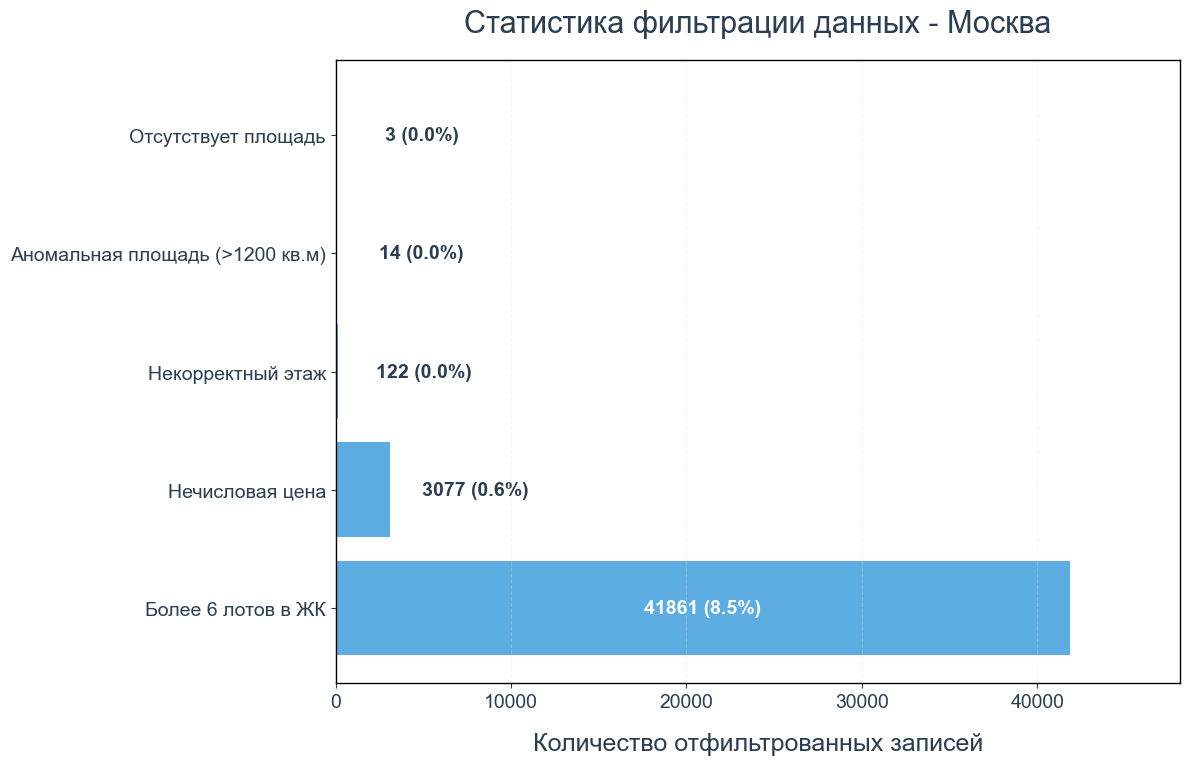

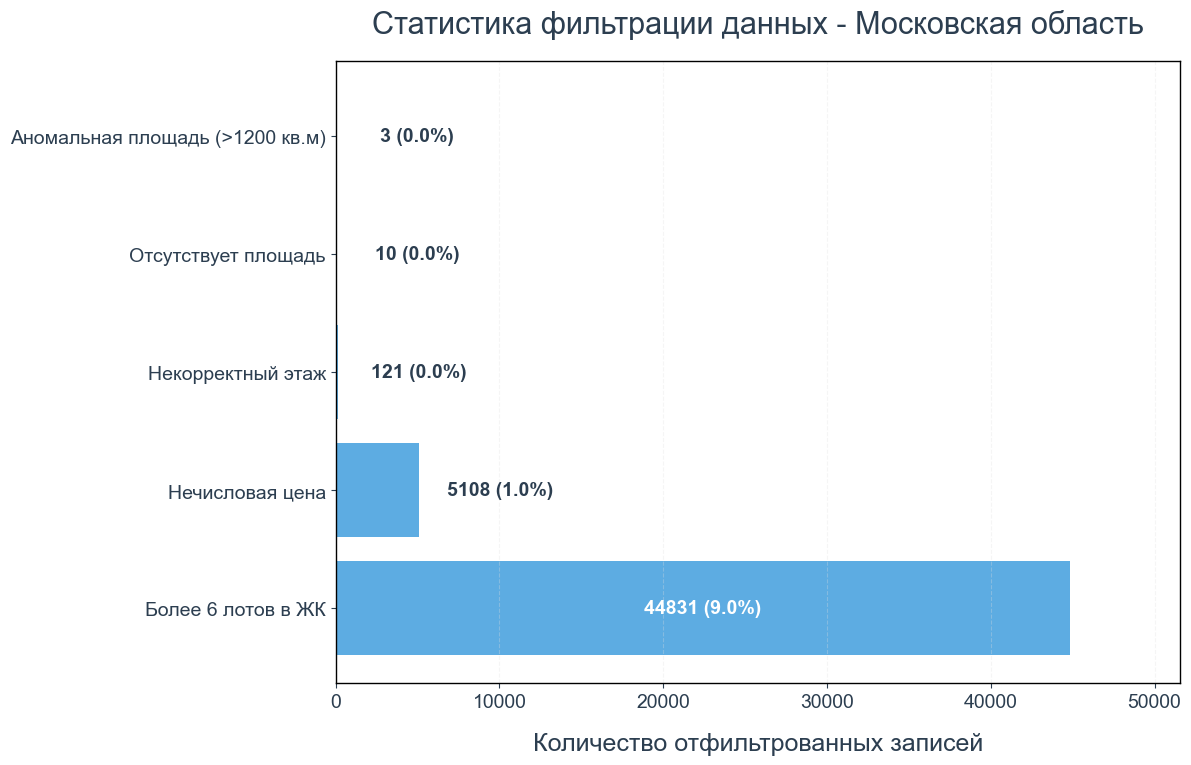

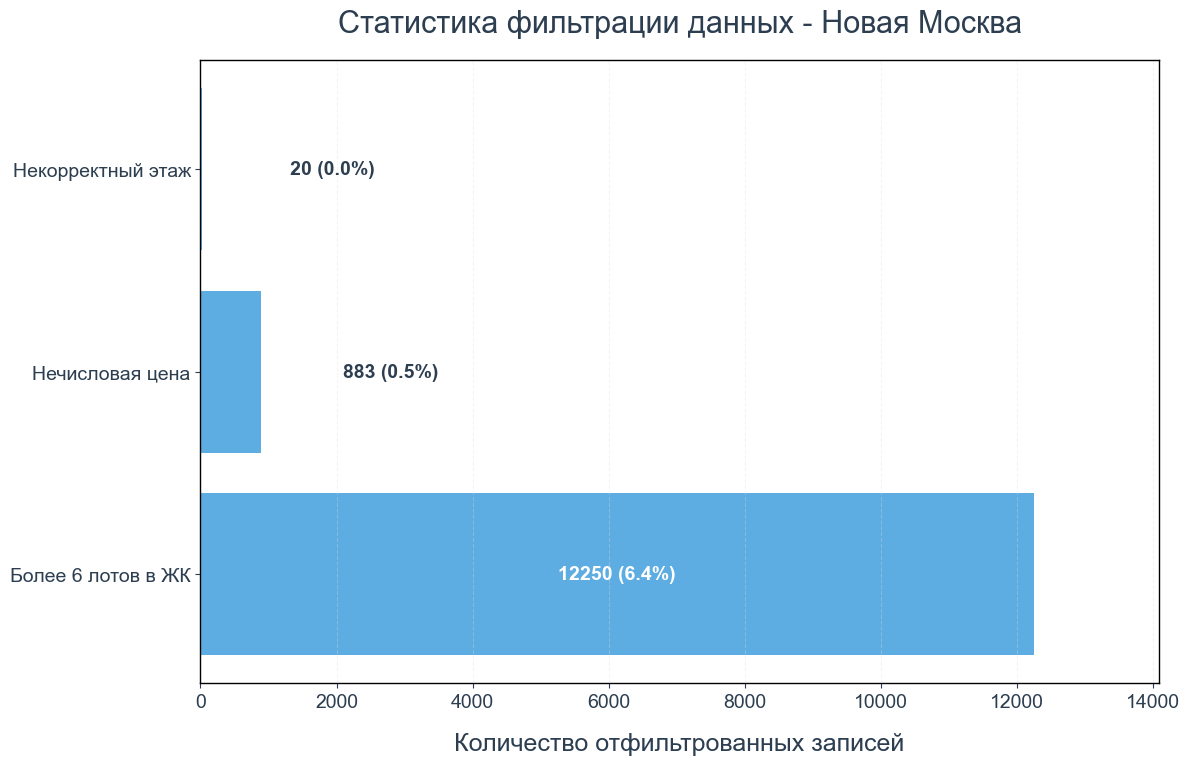

In [19]:
# Визуализация статистики фильтрации для каждого региона
visualize_filter_stats(stats_msk, 'Москва')
visualize_filter_stats(stats_mo, 'Московская область')
visualize_filter_stats(stats_nm, 'Новая Москва')

#### 1.6.2 Функция для создания тепловой карты статистики фильтрации

In [20]:
''' 
Создает тепловую карту статистики фильтрации по всем регионам.
    
Args:
- all_stats: Список словарей со статистикой фильтрации по регионам
- save_path: Путь для сохранения графика
'''
def visualize_heatmap_stats(all_stats, save_path=False):
    
    # Создаем DataFrame для удобства анализа
    regions = [stat['region'] for stat in all_stats]
    
    # Собираем все типы фильтрации из всех регионов
    all_filter_types = set()
    for stat in all_stats:
        for filter_type, count in stat['filtered_records'].items():
            if count > 0 and filter_type not in EXCLUDED_CATEGORIES:
                all_filter_types.add(filter_type)
    
    # Создаем DataFrame с данными по всем регионам
    data = []
    for stat in all_stats:
        row = {'Регион': stat['region'], 'Всего записей': stat['initial_records']}
        for filter_type in all_filter_types:
            row[filter_type] = stat['filtered_records'].get(filter_type, 0)
        data.append(row)
    
    df_stats = pd.DataFrame(data)
    
    # Словарь с более понятными названиями типов фильтрации
    filter_type_names = {
                        'missing_area': 'Отсутствует площадь',
                        'area_outliers': 'Аномальная площадь (>1200 кв.м)',
                        'invalid_floor': 'Некорректный этаж',
                        'excessive_lots': 'Более 6 лотов в ЖК',
                        'non_numeric_price': 'Нечисловая цена'
                        }
    
    # Переименовываем столбцы для более понятных названий
    rename_dict = {k: filter_type_names.get(k, k) for k in all_filter_types}
    df_stats = df_stats.rename(columns=rename_dict)
    
    # Создаем фигуру с улучшенным дизайном
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Преобразуем данные для отображения процентов
    df_percent = df_stats.copy()
    for col in df_percent.columns:
        if col not in ['Регион', 'Всего записей']:
            df_percent[col] = (df_percent[col] / df_percent['Всего записей'] * 100).round(1)
    
    # Транспонируем DataFrame для удобства построения графика
    df_plot = df_percent.set_index('Регион').drop(columns=['Всего записей']).T
    
    # Строим тепловую карту с улучшенным дизайном
    heatmap = sns.heatmap(df_plot, annot=True, cmap=CMAP, fmt='.1f',
                # cbar_kws={'label': '% от общего количества'}, 
                linewidths=1.0, linecolor='white', ax=ax, annot_kws={"size": AXIS_LABEL_FONTSIZE})
    
    # Настраиваем оси и заголовок
    ax.set_title('Процент отфильтрованных записей по типам и регионам', 
                 fontsize=TITLE_FONTSIZE, color=TEXT_COLOR, pad=20)
    ax.set_ylabel('Тип фильтрации', fontsize=AXIS_LABEL_FONTSIZE, color=TEXT_COLOR, labelpad=15)
    ax.set_xlabel('Регион', fontsize=AXIS_LABEL_FONTSIZE, color=TEXT_COLOR, labelpad=15)
    
    # Выделяем оси черным цветом
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(AXIS_COLOR)
        spine.set_linewidth(1.0)
    
    # Увеличиваем размер шрифта для делений на осях
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    
    # Настраиваем colorbar
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=TICK_FONTSIZE)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

#### 1.6.3 Функция для создания столбчатой диаграммы общего количества отфильтрованных записей

In [21]:
'''
Создает столбчатую диаграмму общего количества отфильтрованных записей по регионам.
    
Args:
- all_stats: Список словарей со статистикой фильтрации по регионам
- save_path: Путь для сохранения графика
'''
def visualize_bar_stats(all_stats, save_path=False):
    
    # Создаем фигуру с улучшенным дизайном
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Рассчитываем общее количество отфильтрованных записей для каждого региона
    regions = [stat['region'] for stat in all_stats]
    total_filtered = [stat['total_filtered'] for stat in all_stats]
    percent_filtered = [stat['percent_filtered'] for stat in all_stats]
    
    # Строим столбчатую диаграмму с градиентной заливкой
    bars = ax.bar(regions, total_filtered, color=MAIN_COLOR, alpha=0.8, width=0.6)
    
    # Добавляем подписи с количеством и процентами
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.02, 
                f"{total_filtered[i]}\n({percent_filtered[i]:.1f}%)", 
                ha='center', va='bottom', fontsize=TICK_FONTSIZE, color=TEXT_COLOR,
                fontweight='bold')
    
    # Настраиваем оси и заголовок
    ax.set_title('Общее количество отфильтрованных записей по регионам', 
                 fontsize=TITLE_FONTSIZE, color=TEXT_COLOR, pad=20)
    ax.set_ylabel('Количество записей', fontsize=AXIS_LABEL_FONTSIZE, color=TEXT_COLOR, labelpad=15)
    ax.grid(axis='y', alpha=0.3, color=GRID_COLOR, linestyle='--')
    
    # Выделяем оси черным цветом
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(AXIS_COLOR)
        spine.set_linewidth(1.0)
    
    # Увеличиваем размер шрифта для делений на осях
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()

#### 1.6.4 Основной код для обработки данных и визуализации статистики

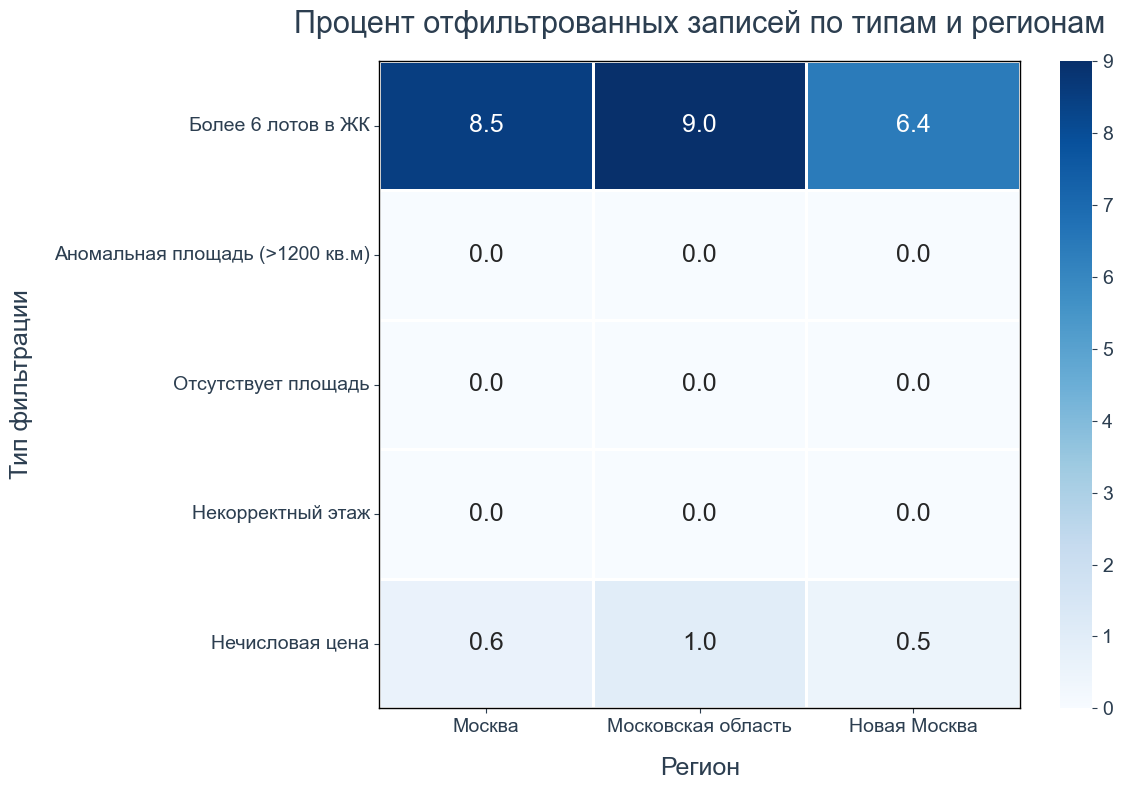

In [22]:
## Создаем сводную визуализацию по всем регионам - разделяем на два графика
all_stats = [stats_msk, stats_mo, stats_nm]

visualize_heatmap_stats(all_stats)
# visualize_bar_stats(all_stats)